In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm

from math import log2
from random import choices
from scipy.sparse import dok_matrix, csr_matrix, dok_array, hstack, vstack
from scipy.spatial.distance import cosine, euclidean
from scipy.sparse.linalg import svds, inv

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import TruncatedSVD, PCA

from tensorflow.keras.layers import Input, Dot, Embedding, Dense, Flatten, Lambda, Concatenate, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

# GloVe Embedding

In [36]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [37]:
M = len(all_words)
M

100649

In [38]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## Computation of the co-ocurrence matrix

In [6]:
def count_word_coocurrence(docs, vocab, wsize=10):
    term_term_dict = {}
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    M = len(vocab)
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [7]:
word_cooc_matrix = count_word_coocurrence(docs, all_words, wsize=5)

## Creating glove neural network estimator for a subset of the data, the 10 first documents

In [6]:
temp_docs = docs[:10]

In [7]:
temp_words = {}
i=0
for doc in temp_docs:
    for word in doc:
        if word not in temp_words:
            temp_words|={word:i}
            i+=1

In [8]:
temp_rev = {item[1]:item[0] for item in temp_words.items()}

In [9]:
def word2int(word):
    return temp_words[word]

def int2word(idx):
    return temp_rev[idx]

In [10]:
word_cooc_matrix = count_word_coocurrence(temp_docs, temp_words, wsize=5)

In [11]:
word_cooc_matrix

<135x135 sparse matrix of type '<class 'numpy.float64'>'
	with 751 stored elements in Dictionary Of Keys format>

##### ChatGPT3 implementation

In [41]:
#Defined by GPT3
input_shape = (word_cooc_matrix.shape[0],)

input_layer = Input(shape=input_shape, name='input_layer')

embedding_layer = Dense(units=50, activation='relu', name='embedding_layer')(input_layer)

output_layer = Dense(units=word_cooc_matrix.shape[0], activation='sigmoid', name='output_layer')(embedding_layer)

dot_layer = Dot(axes=1, name='dot_layer')([output_layer, input_layer])

output = Flatten(name='output')(dot_layer)

In [42]:
model = Model(inputs=input_layer, outputs=output)
model.compile(loss='mse', optimizer='adam')

In [61]:
model.fit(x=word_cooc_matrix.toarray(), y=word_cooc_matrix.toarray(), epochs=10, batch_size=1)

Epoch 1/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0553
Epoch 2/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0549
Epoch 3/10
135/135 [==============================] - 1s 5ms/step - loss: 0.0546
Epoch 4/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0544
Epoch 5/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0542
Epoch 6/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0540
Epoch 7/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0538
Epoch 8/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0537
Epoch 9/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0536
Epoch 10/10
135/135 [==============================] - 1s 6ms/step - loss: 0.0535


In [62]:
u = PCA().fit_transform(model.get_weights()[0])

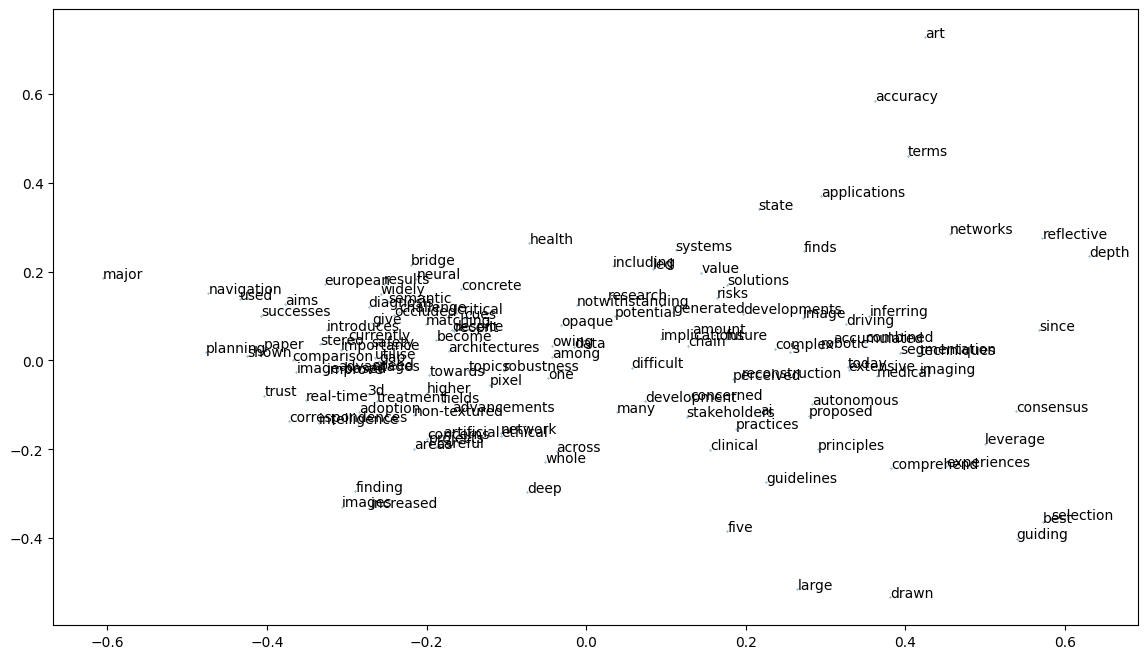

In [63]:
plt.figure(figsize=(14,8))

plt.scatter(u[:,0], u[:,1], s=0.1)
for i in range(135):
    plt.text(u[i,0], u[i,1],int2word(i))

##### My implementation

In [24]:
def get_training_sets(cooc: dok_matrix):
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [25]:
X, y = get_training_sets(word_cooc_matrix)

In [27]:
X.shape

(751, 2)

In [29]:
EMB_SIZE=50

In [77]:
word_cooc_matrix.shape[0]

135

In [114]:
target = Input(shape=1, name="context_input")
context = Input(shape=1, name="target_input")

embed_layer = Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot_layer = Dot(axes=2)( [ embed_target, embed_context ] )
flat = Flatten()(dot_layer)

model = Model(inputs=[ target, context ], outputs=flat)

In [115]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )


In [116]:
model.compile(optimizer="adam", loss=loss)

In [117]:
model.fit([ X[:,0], X[:,1] ], y, epochs=10, batch_size=1)

Epoch 1/10
751/751 [==============================] - 6s 8ms/step - loss: 0.0028
Epoch 2/10
751/751 [==============================] - 5s 6ms/step - loss: 0.0017
Epoch 3/10
751/751 [==============================] - 5s 6ms/step - loss: 9.5822e-04
Epoch 4/10
751/751 [==============================] - 5s 6ms/step - loss: 7.4030e-04
Epoch 5/10
751/751 [==============================] - 5s 6ms/step - loss: 5.9728e-04
Epoch 6/10
751/751 [==============================] - 5s 6ms/step - loss: 5.3113e-04
Epoch 7/10
751/751 [==============================] - 5s 6ms/step - loss: 4.9374e-04
Epoch 8/10
751/751 [==============================] - 5s 6ms/step - loss: 4.8283e-04
Epoch 9/10
751/751 [==============================] - 5s 6ms/step - loss: 4.4305e-04
Epoch 10/10
751/751 [==============================] - 5s 7ms/step - loss: 4.1819e-04


In [118]:
model.get_weights()[0].shape

(135, 50)

In [119]:
u = PCA().fit_transform(model.get_weights()[0])

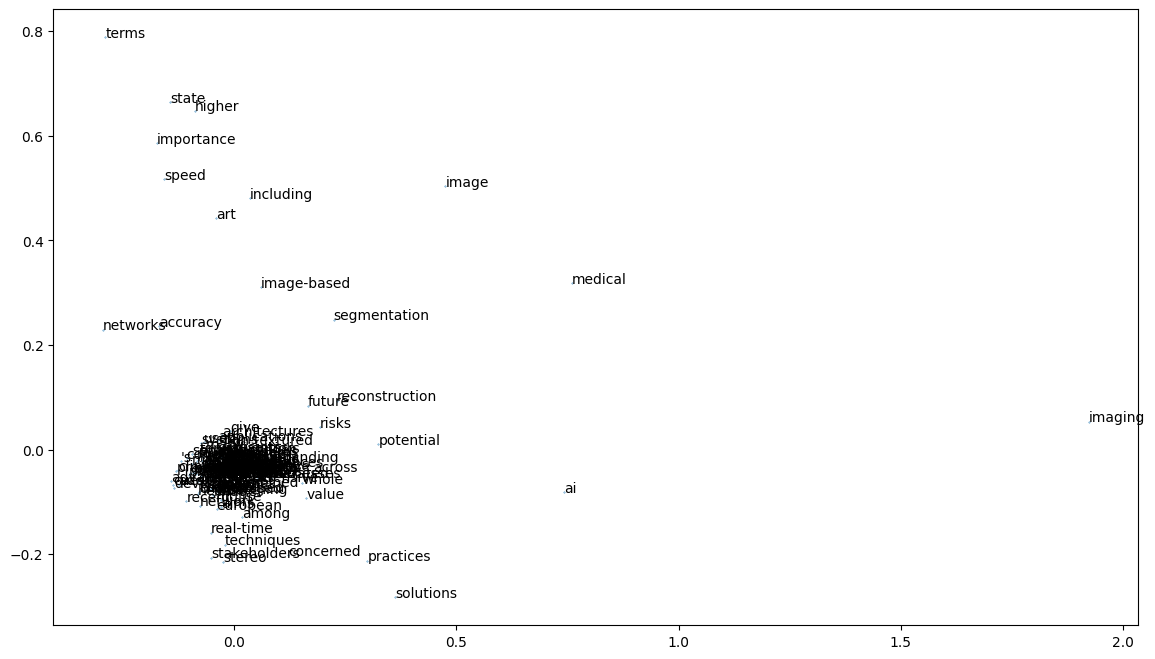

In [120]:
plt.figure(figsize=(14,8))

plt.scatter(u[:,0], u[:,1], s=0.1)
for i in range(135):
    plt.text(u[i,0], u[i,1],int2word(i))

In [128]:
np.argsort([
    euclidean( 
        model.get_weights()[0][word2int("image")],
        model.get_weights()[0][i]
    ) for i in range(len(model.get_weights()[0]))
])[:15]

array([ 40,  85,  41,  86,  87,  24,  93,  43,  20,   4, 109,  91,  38,
        89,  22], dtype=int64)

In [130]:
int2word(22)

'navigation'

## Creating GloVe neural network estimator for all the dataset

In [8]:
def get_training_sets(cooc: dok_matrix):
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [9]:
X, y = get_training_sets(word_cooc_matrix)

In [10]:
X.shape

(6134986, 2)

In [11]:
EMB_SIZE=50

In [12]:
target = Input(shape=1, name="context_input")
context = Input(shape=1, name="target_input")

embed_layer = Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot_layer = Dot(axes=2)( [ embed_target, embed_context ] )
flat = Flatten()(dot_layer)

model = Model(inputs=[ target, context ], outputs=flat)

In [13]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )

In [14]:
model.compile(optimizer="adam", loss=loss)

In [20]:
model.fit([ X[:,0], X[:,1] ], y, epochs=10, batch_size=64)

In [16]:
embed_vectors = model.get_weights()[0]

In [17]:
u = PCA().fit_transform(embed_vectors)

In [74]:
np.argsort([
    euclidean( 
        embed_vectors[word2int("cnn")],
        embed_vectors[i]
    ) for i in range(embed_vectors.shape[0])
])[:15]

array([  992,   489,   488,    68,   450, 31480, 25362, 56725,  1063,
       36925,  1292, 56726, 41913, 60365,  2767], dtype=int64)

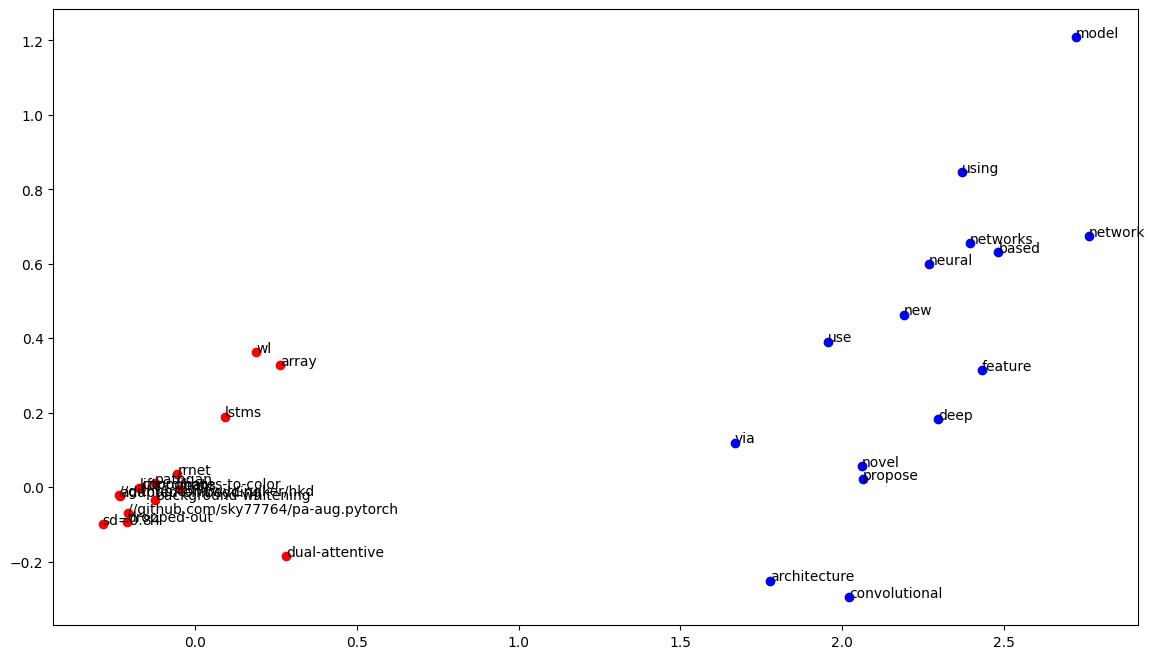

In [92]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("network")], 
        u[i]
    ) for i in range(len(u))
])[:15]

random = np.random.choice(list(range(len(u))), size=15, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

In [87]:
model.save("gloVe.h5")

# Word2Vec Embedding

In [2]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [3]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## CBOW

In [4]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            context_set = tuple(sorted(context_set))
            
            dataset[context_set] = dataset.get(context_set, set()) | {current_word}
    return dataset

In [5]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

In [6]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

### Full dataset


#### 1. Testing CBOW with the default mode (predicting correct class)

In [7]:
M = len(all_words)

In [9]:
wsize=4

In [10]:
ds = get_dataset(docs, wsize)

In [11]:
X,y = unwind(ds)

In [12]:
EMB_SIZE=50

In [ ]:
model = Sequential([
    Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    Dense(units=M, activation="softmax", name="activation_layer")
])
    

In [48]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [ ]:
model.fit(x=X, y=y, batch_size=128, epochs=1)

In [23]:
model.save("cbow.h5")

In [27]:
embed_vectors = model.get_weights()[0]

In [28]:
pca = PCA().fit_transform(embed_vectors)

In [57]:
np.argsort([ 
    euclidean(
        pca[word2int("bridge")], 
        pca[i]
    ) for i in range(len(pca))
])[:15]

array([   11, 12934, 31193,  2919, 28473, 32610, 83848, 74653, 89796,
        7153, 56906, 37408, 50647, 62902, 56907], dtype=int64)

In [ ]:
int2word(32610)

In [66]:
list(all_words.keys())[1200:1225]

['endowed',
 'boundary',
 'artifacts',
 'refining',
 'contours',
 'generation',
 'final',
 'codes',
 '//github.com/liqiokkk/fctl',
 '-dimensional',
 'whereby',
 'clustered',
 'edge',
 'general',
 'probabilistic',
 'mathematical',
 'devised',
 'thresholds',
 'calculated',
 'indicate',
 'randomly-generated',
 'points',
 'projected',
 'structures',
 'partition']

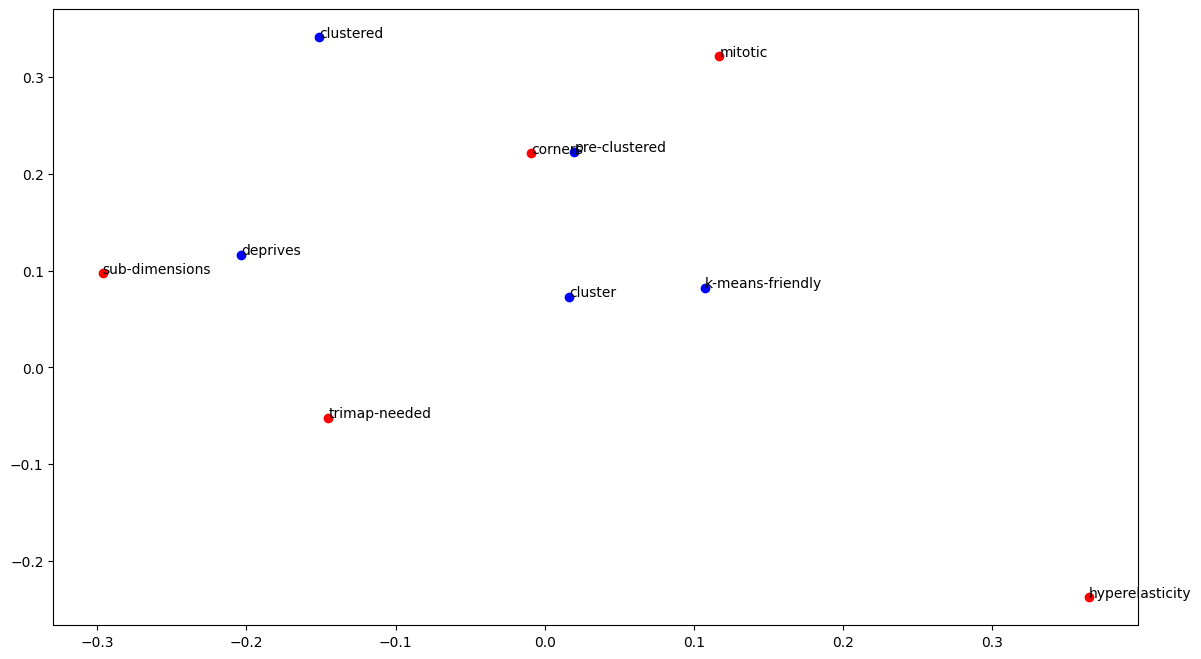

In [67]:
k=5
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("cluster")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))

#### 2. CBOW with negative sampling

In [6]:
wsize=4

In [7]:
ds = get_dataset(docs, wsize)

In [8]:
context_words, target_words = unwind(ds)

In [9]:
context_words.shape

(1949427, 8)

In [10]:
k=5
M = len(all_words)
EMB_DIM = 50

In [11]:
context = Input(shape=wsize*2)
target = Input(shape=1)
n_targets = Input(shape=k)

embedding_layer = Embedding(M, EMB_DIM, name="emb_layer")
mean_layer = Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=(EMB_DIM))
reshape_layer = Reshape((1, EMB_DIM))
dot_layer = Dot(axes=2)
concat = Concatenate()

cemb = embedding_layer(context)
cemb = mean_layer(cemb)
cemb = reshape_layer(cemb)

temb = embedding_layer(target)
nemb = embedding_layer(n_targets)

out = dot_layer([cemb, temb])
n_out = dot_layer([-cemb, nemb])

out = concat([out, n_out])

model = Model(inputs=[context, target, n_targets], outputs=out)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 emb_layer (Embedding)          multiple             5032450     ['input_1[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 50)           0           ['emb_layer[0][0]']              
                                                                                              

In [13]:
vocab = list(all_words.values())

In [18]:
def epochs_generator(context_words, target_words, n_nsamples, batch_size=1, epochs=1):
    idx = np.arange(context_words.shape[0], dtype=int)
    np.random.shuffle(idx)
    context_words = context_words[idx]
    target_words = target_words[idx]    
    
    i = 0
    while i < int(context_words.shape[0]):
        c = context_words[i:i+batch_size]
        t = target_words[i:i+batch_size]
        
        new_shape = len(c)
        
        n_targets = np.array(
            choices(vocab, k=n_nsamples*new_shape)
        ).reshape(n_nsamples, new_shape)
        
        c = c.reshape(new_shape,-1)
        t = t.reshape(new_shape,-1)
        n = n_targets.reshape(new_shape,-1)

        out = np.array([[1] + [0]*n_nsamples]*new_shape).reshape(new_shape,-1)
        yield ([c, t, n], out)
        i+=batch_size

In [27]:
@tf.function
def cbow_loss(y_test, preds):
    return -tf.reduce_sum(
        tf.math.log_sigmoid(preds)
    )

In [28]:
model.compile("adam", cbow_loss)

In [ ]:
batch_size=32
model.fit(
    epochs_generator(context_words, target_words, k, batch_size), 
    steps_per_epoch=np.ceil(len(context_words)/batch_size)
)

11523/60920 [====>.........................] - ETA: 10:27 - loss: 246198.7031

In [89]:
model.save("models/cbow_negative_sampling.h5")

In [22]:
embed_vectors = model.get_weights()[0]

In [23]:
pca = PCA().fit_transform(embed_vectors)

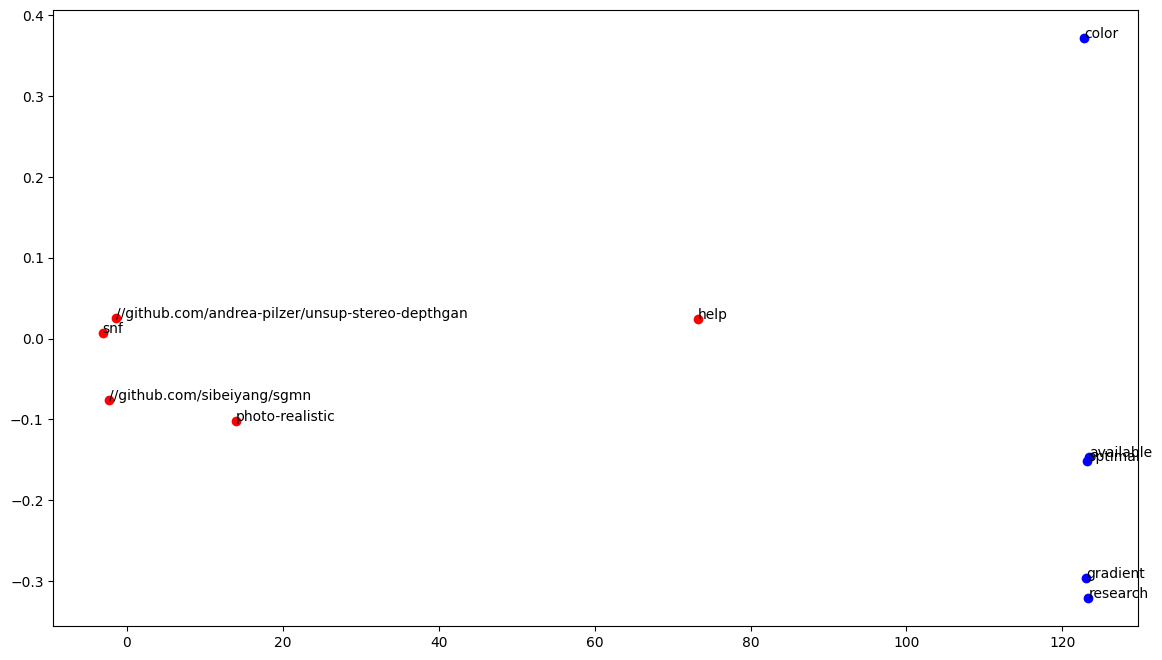

In [26]:
k=5
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("research")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))

## Skip-gram

##### (following tensorflow tutorial)

In [19]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for i,doc in enumerate(docs):
        N = len(doc)
        if i%25000==0:
            print(i)
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            dataset[current_word] = dataset.get(current_word, set()) | set(context_set)

    return dataset

In [ ]:
ds = get_dataset(docs)

In [102]:
ds = { key:list(value) for key,value in ds.items()}

In [113]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y)

In [114]:
target, context = unwind(ds)

In [127]:
context[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [121]:
def generate_training_data(targets, contexts, vocab, n_nsamples=3):
    new_target, new_context, labels = [], [], []
    N = len(vocab)
    
    for target, context in tqdm.tqdm(zip(targets, contexts)):
        new_target.append(target)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=[[1]],
                num_true=1,
                num_sampled=n_nsamples,
                unique=True,
                range_max=N,
                name="negative_sampling"
        )
        
        #join positive and negative samples
        temp = [context] + list(negative_sampling_candidates.numpy())
        new_context.append(temp)
        
        labels.append([1] + [0]*n_nsamples)

    return np.array(new_target), np.array(new_context), np.array(labels)

In [ ]:
target, context, label = generate_training_data(target, context, all_words)

In [38]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

In [39]:
dataset = tf.data.Dataset.from_tensor_slices(((target, context), label))

In [40]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024,), dtype=tf.int64, name=None)), TensorSpec(shape=(1024,), dtype=tf.int32, name=None))>


In [42]:
dataset = dataset.cache().prefetch(buffer_size=-1)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024,), dtype=tf.int64, name=None)), TensorSpec(shape=(1024,), dtype=tf.int32, name=None))>


In [95]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_ns):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(
            vocab_size,
            embedding_dim,
            input_length=1,
            name="w2v_embedding"
        )
        self.context_embedding = Embedding(
            vocab_size,
            embedding_dim,
            input_length=1
        )
        
    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
            
        # target: (batch,)
        word_emb = self.target_embedding(target)
        
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        print(word_emb)
        print(context_emb)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)

        #dots = tf.math.reduce_prod(word_emb+context_emb, axis=0)
        
        # dots: (batch, context)
        return dots

In [96]:
embedding_dim = 50
word2vec = Word2Vec(len(all_words), embedding_dim, 3)
word2vec.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
word2vec.fit(dataset, epochs=5)

In [73]:
target[:5]

array([2, 2, 2, 2, 2])

### Tensorflow functional api

In [92]:
target = Input(shape=1)

emb = Embedding(input_dim=M, output_dim=EMB_SIZE, input_length=1, name="embedding_layer")
temb = Flatten()(emb(target))

dense_layers = [Dense(M, activation="softmax", name=f"output_{i}") for i in range(wsize*2)]

outputs = [dense(temb) for dense in dense_layers]
model = Model(inputs=target, outputs=outputs)

In [95]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [96]:
model.fit(x=y, y=X.reshape(1949427, 8, 1), batch_size=1, epochs=1)

ValueError: in user code:

    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "C:\Users\joelp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(8,) and logits.shape=(1, 100649)


In [63]:
len(model.predict(y[:1]))

1/1 [==============================] - 0s 36ms/step


8

In [80]:
model.predict(y[0])

1/1 [==============================] - 0s 123ms/step


[array([[9.946999e-06, 9.932185e-06, 9.935987e-06, ..., 9.943445e-06,
         9.933872e-06, 9.931441e-06]], dtype=float32),
 array([[9.915766e-06, 9.949229e-06, 9.933055e-06, ..., 9.953596e-06,
         9.947251e-06, 9.927553e-06]], dtype=float32),
 array([[9.937316e-06, 9.935024e-06, 9.928942e-06, ..., 9.939110e-06,
         9.938278e-06, 9.941900e-06]], dtype=float32),
 array([[9.935431e-06, 9.955023e-06, 9.927382e-06, ..., 9.941391e-06,
         9.935038e-06, 9.927866e-06]], dtype=float32),
 array([[9.9289082e-06, 9.9425415e-06, 9.9335848e-06, ..., 9.9351873e-06,
         9.9273293e-06, 9.9327408e-06]], dtype=float32),
 array([[9.929140e-06, 9.936266e-06, 9.935566e-06, ..., 9.924861e-06,
         9.936135e-06, 9.930769e-06]], dtype=float32),
 array([[9.9433482e-06, 9.9516119e-06, 9.9250865e-06, ..., 9.9294357e-06,
         9.9314739e-06, 9.9531744e-06]], dtype=float32),
 array([[9.9440413e-06, 9.9401141e-06, 9.9389636e-06, ..., 9.9411545e-06,
         9.9333820e-06, 9.9373610e-06]]

In [82]:
X.reshape(1949427, 1 ,8)

array([[[   0,    0,    1, ...,    5,    6,    7]],

       [[   0,    1,    2, ...,    6,    7,    8]],

       [[   0,    2,    3, ...,    7,    8,    9]],

       ...,

       [[  23,  213,  420, ..., 1280, 2223, 6964]],

       [[  23,   71,  216, ...,  847, 1280, 6964]],

       [[  71,  213,  216, ...,  530,  847, 1280]]])